# CAPSTONE ASSIGNMENT
## Battle of the Neighborhoods
### __Italian Restaurants in NYC__
### -------------------------------------------------------------------------------------------------------

#### __Introduction__
This final project explores the best locations for Italian restaurants throughout the city of New York. Food Business News stated that worldwide pasta sales were up for the second year in a row with the United Sates holding the largest market (Donley, 2018).  New York is a major metropolitan area with more than 8.4 million (Quick Facts, 2018) people living within city limits. Most of the Italian immigration into the United States occurred during the late 19th and early 20th century with over two million immigrants between 1900 and 1910.  Italian families first settled in Little Italy’s neighborhood around Mulberry Street as has continued to thrive ever since.  With almost 700,000 Manhattan inhabitants reporting Italian ancestry, the need to find and enjoy Italian cuisine is on the rise.  This report explores which neighborhoods and boroughs of New York City have the most as well as the best Italian restaurants. Additionally, I will attempt to answer the questions “Where should I open an Italian Restaurant?” and “Where should I stay If I want great Italian food?”

### __Data__
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Italian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.



### __Methodology__
•	Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

•	FourSquare be used to locate all venues and then filtered by Italian restaurants.  Ratings, tips, and likes by users will be counted and added to the dataframe.

•	Data will be sorted based on rankings

•	Finally, the data be will be visually assessed using graphing from various Python libraries.

### __Problem Statement__
1.	What is / are the best location(s) for Italian cuisine in New York City?
2.	In what Neighborhood and/or borough should I open an Italian restaurant to have the best chance of being successful?
3.	Where would I go in New York City to have the best Italian food?

Load Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be 

My variables

Functions that will be used later

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Now lets use the above codes to get our initial NYC data

In [4]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
ny_data.shape

(306, 4)

Data Analysis - Manhattan has the least number of neighborhoods in all listed buroughs

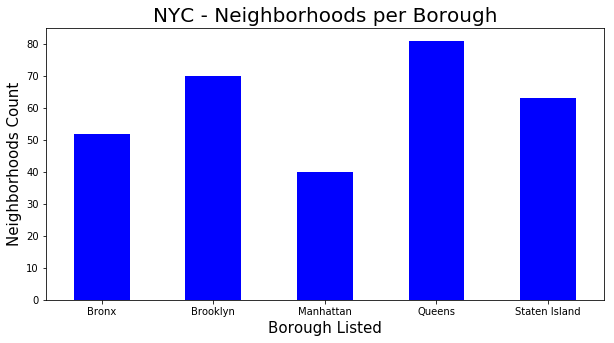

In [6]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('NYC - Neighborhoods per Borough', fontsize = 20)
plt.xlabel('Borough Listed', fontsize = 15)
plt.ylabel('Neighborhoods Count',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Now, we will analyze that number of italaian resturant in each neighborhood/burough

In [7]:
# prepare neighborhood list that contains Italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Italian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Italian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Italian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Italian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Italian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Italian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Italian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Italian Resturants in Norwood, Bronx:0
['Bronx', '

In [8]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [9]:
italian_rest_ny = pd.read_csv('italian_rest_ny_tocsv1.csv')
italian_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
230,230,Queens,Sunnyside Gardens,5699aa86498ef437b2fd7102,Zio Luigi
231,231,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's
232,232,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's
233,233,Staten Island,Prince's Bay,4c091311a1b32d7f5efb96f0,Certo's Gourmet Foods & Caterers
234,234,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde


In [11]:
italian_rest_ny.shape

(235, 5)

In continuation with data analysis, we see below that although Manhattan had the least number of nieghborhoods buthave the highest number of Italian restaurants.  Additionally, we see how many restaurants the top 6 neighborhoods have.  The neighborhood of Belmont has the highest number of Italian restaurants in all of NYC and is actually located in the burough of Bronx vice Manhattan.

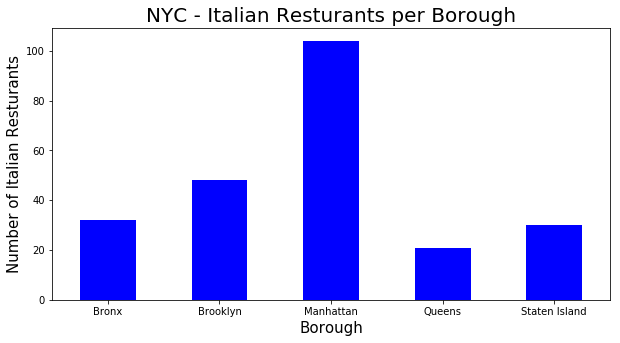

In [12]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('NYC - Italian Resturants per Borough', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Number of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

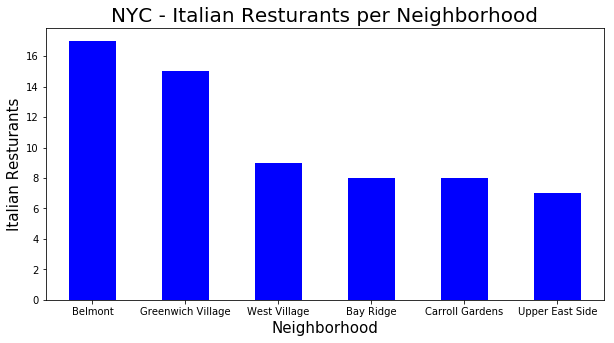

In [13]:
NOofNeigh = 6 # top number for graphing all the same past 6
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('NYC - Italian Resturants per Neighborhood', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [ ]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

In [14]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
#column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
italian_rest_ny.values.tolist()

[[0,
  'Bronx',
  'Woodlawn',
  '511edb6de4b0d58346fd272d',
  "Patrizia's Of Woodlawn"],
 [1, 'Bronx', 'Pelham Parkway', '4bf96ae65317a593d837017f', "Enzo's"],
 [2, 'Bronx', 'Pelham Parkway', '4b47f069f964a5208c4426e3', 'Pasta Pasta'],
 [3,
  'Bronx',
  'City Island',
  '4514ed4df964a520e5391fe3',
  "Artie's Steak and Seafood"],
 [4, 'Bronx', 'Country Club', '4be35e62b02ec9b6b66b4fc0', "Vibano's"],
 [5,
  'Bronx',
  'Parkchester',
  '5197f6507dd2310725c35f1e',
  "Lorraine's Bar and Grill"],
 [6, 'Bronx', 'Morris Park', '4b10591af964a5205f6e23e3', "Patricia's"],
 [7, 'Bronx', 'Belmont', '4acf80aef964a52025d420e3', "Tino's Delicatessen"],
 [8,
  'Bronx',
  'Belmont',
  '4af71916f964a520cf0522e3',
  "Michaelangelo's Coal Fired Brick Oven Pizza Restaurant"],
 [9, 'Bronx', 'Belmont', '4bb6470cef159c7465b275f7', 'Calabria Pork Store'],
 [10, 'Bronx', 'Belmont', '4aa425bef964a5208e4520e3', "Dominick's Restaurant"],
 [11, 'Bronx', 'Belmont', '4af0fa29f964a52060e021e3', "Antonio's Trattoria"],


In [15]:
column_names=['Seq','Borough', 'Neighborhood', 'ID','Name']
#column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Seq,Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5dcd80a5b4b684001b9bdfd3'}, 'response': {'venue': {'id': '511edb6de4b0d58346fd272d', 'name': "Patrizia's Of Woodlawn", 'contact': {'phone': '7188845700', 'formattedPhone': '(718) 884-5700'}, 'location': {'address': '4358 Katonah Ave', 'lat': 40.900638399332884, 'lng': -73.86772361835486, 'labeledLatLngs': [{'label': 'display', 'lat': 40.900638399332884, 'lng': -73.86772361835486}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4358 Katonah Ave', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-woodlawn/511edb6de4b0d58346fd272d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'http:

KeyError: 'venue'

In [16]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv') 

In [17]:
italian_rest_stats_ny.shape

(50, 8)

In [18]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
Seq             0 non-null float64
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(4), object(4)
memory usage: 3.2+ KB


In [19]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
Seq             0 non-null float64
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(4), object(4)
memory usage: 3.2+ KB


In [20]:
italian_rest_stats_ny.describe()

,Seq,Likes,Rating,Tips
count,0.0,50.000000,50.000,50.000000
mean,NaN,31.340000,6.862,14.820000
std,NaN,34.729632,2.671,13.109725
min,NaN,0.000000,0.000,0.000000
25%,NaN,7.500000,7.000,4.250000
50%,NaN,17.500000,7.700,10.500000
75%,NaN,42.750000,8.200,21.750000
max,NaN,144.000000,9.400,48.000000


In [21]:
# Resturant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Seq                                  NaN
Borough                            Bronx
Neighborhood                     Belmont
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                144
Rating                               9.2
Tips                                  48
Name: 7, dtype: object

In [22]:
# Resturant with maximum Ratings
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Seq                                  NaN
Borough                         Brooklyn
Neighborhood                 Cobble Hill
ID              5a0740a3e1f22816d11723d5
Name                               Lillo
Likes                                 44
Rating                               9.4
Tips                                   9
Name: 46, dtype: object

In [23]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Seq                                  NaN
Borough                            Bronx
Neighborhood                     Belmont
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                144
Rating                               9.2
Tips                                  48
Name: 7, dtype: object

In [24]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
3,Bushwick,9.300000
12,Morris Park,8.500000
6,Cobble Hill,8.433333
16,Pelham Gardens,8.400000
4,Carroll Gardens,8.300000
5,City Island,8.200000
19,Woodlawn,8.100000
11,Greenpoint,8.000000
1,Belmont,7.952941
2,Bensonhurst,7.750000


In [25]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,7.074194
1,Brooklyn,6.515789


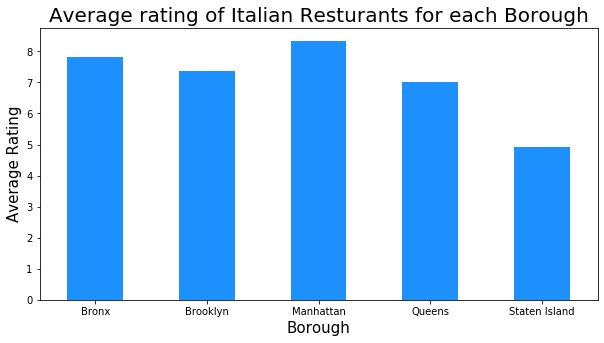

In [51]:
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Italian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

We will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the approprite dfs to include latitudes and longitudes.

In [26]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
3,Bushwick,9.300000
4,Carroll Gardens,8.300000
5,City Island,8.200000
6,Cobble Hill,8.433333
11,Greenpoint,8.000000
12,Morris Park,8.500000
16,Pelham Gardens,8.400000
19,Woodlawn,8.100000


In [30]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bushwick,40.698116,-73.925258,9.300000
1,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.300000
2,Bronx,City Island,40.847247,-73.786488,8.200000
3,Brooklyn,Cobble Hill,40.687920,-73.998561,8.433333
4,Brooklyn,Greenpoint,40.730201,-73.954241,8.000000
5,Bronx,Morris Park,40.847549,-73.850402,8.500000
6,Bronx,Pelham Gardens,40.862966,-73.841612,8.400000
7,Bronx,Woodlawn,40.898273,-73.867315,8.100000


In [36]:
#ny_neighborhood_stats[['Latitude','Longitude']].values
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,Brooklyn,Bushwick,40.698116,-73.925258,9.300000,"Bushwick, Brooklyn(9.3)"
1,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.300000,"Carroll Gardens, Brooklyn(8.3)"
2,Bronx,City Island,40.847247,-73.786488,8.200000,"City Island, Bronx(8.2)"
3,Brooklyn,Cobble Hill,40.687920,-73.998561,8.433333,"Cobble Hill, Brooklyn(8.433333333333334)"
4,Brooklyn,Greenpoint,40.730201,-73.954241,8.000000,"Greenpoint, Brooklyn(8.0)"
5,Bronx,Morris Park,40.847549,-73.850402,8.500000,"Morris Park, Bronx(8.5)"
6,Bronx,Pelham Gardens,40.862966,-73.841612,8.400000,"Pelham Gardens, Bronx(8.4)"
7,Bronx,Woodlawn,40.898273,-73.867315,8.100000,"Woodlawn, Bronx(8.1)"


In [38]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [39]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [41]:
!wget -q -O 'Borough Boundaries.geojson' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [43]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

Finally, we will visualize all NYC buroughs based on average Rating.

In [46]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')
ny_map

click [here](https://github.com/nasloot90/coursera-class/blob/master/chlor2.JPG) to see the chorpleth map of average ratings

### __Results / Conclusion__
Manhattan and Queens have the best rated Italian restaurants on average. Queens and The Bronx have the least amount of Italian restaurants per borough. However, of note, Belmont of The Bronx is the neighborhood in all of NYC with the most Italian Restaurants. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most Italian restaurants.  Based on this information, I would state that Manhattan and Queens are the best locations for Italian cuisine in NYC. To have the best shot of success, I would open an Italian restaurants in Queens. Queens has multiple neighborhoods with average ratings exceeding 8.0 of a scale of 1.0 to 10.0 and has the least number of Italian restaurants making competition easier than in other boroughs. Finally, I would go to Gramercy in Manhattan for the best Italian food based on 131 likes. As a final note, all of the above analysis is depended  on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.